In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


In [139]:
datasets = ["BAC"]


for dataset in datasets:
    Ticker = yf.Ticker(dataset)
    data = Ticker.history(start="2023-01-01", end="2023-10-06")
    filename = f"{dataset}_data.csv"
    data.to_csv(filename)
    print(f"Download data for {dataset} and saved as {filename}")

Download data for BAC and saved as BAC_data.csv


In [175]:
Ticker='BAC'
start_date = '2023-08-01'
end_date ='2023-10-06'
data_0 = yf.download(Ticker, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [176]:
data_0.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-29,27.889999,27.990000,27.270000,27.379999,27.379999,40613400
2023-10-02,27.270000,27.360001,26.580000,26.700001,26.700001,50388600
2023-10-03,26.490000,26.520000,25.820000,25.910000,25.910000,62144500
2023-10-04,25.879999,26.010000,25.580000,25.940001,25.940001,55696400
2023-10-05,25.780001,26.090000,25.559999,26.059999,26.059999,49044100


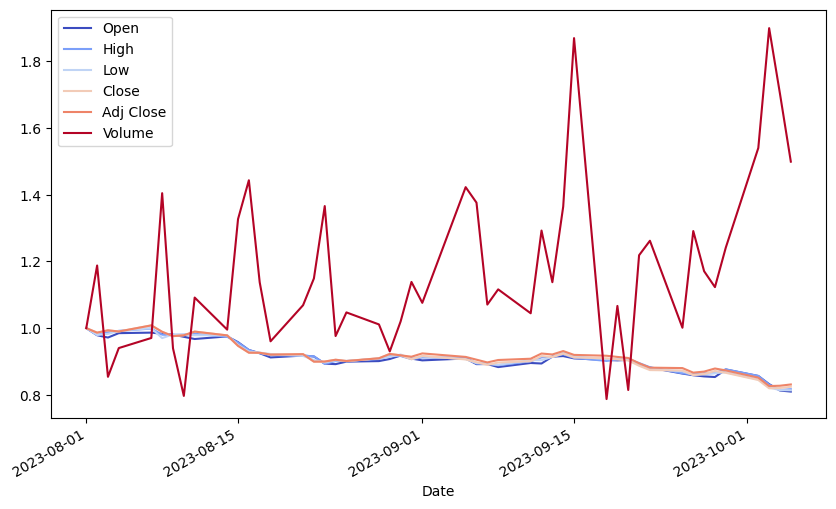

In [177]:
(data_0/data_0.iloc[0]).plot(figsize=(10,6), cmap='coolwarm');

In [178]:
lags = 7




In [179]:
def add_lags(data_0, ric, lags):
    cols = []
    df = pd.DataFrame(data_0[ric])
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        df[col] = df[ric].shift(lag)
        cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [180]:
dfs = {}
for sym in data_0.columns:
    df, cols= add_lags(data_0, sym, lags)
    dfs[sym] = df

In [181]:
dfs[sym].head()

,Volume,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2023-08-10,26062600,30732100.0,45951800.0,31745200.0,30755100.0,27933400.0,38855100.0,32712000.0
2023-08-11,35709900,26062600.0,30732100.0,45951800.0,31745200.0,30755100.0,27933400.0,38855100.0
2023-08-14,32563700,35709900.0,26062600.0,30732100.0,45951800.0,31745200.0,30755100.0,27933400.0
2023-08-15,43406100,32563700.0,35709900.0,26062600.0,30732100.0,45951800.0,31745200.0,30755100.0
2023-08-16,47220400,43406100.0,32563700.0,35709900.0,26062600.0,30732100.0,45951800.0,31745200.0


# **Regression Analysis**

In [182]:
regs={}
for sym in data_0.columns:
    df = dfs[sym]
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    regs[sym] = reg

In [183]:
rega = np.stack(tuple(regs.values()))

In [184]:
regd = pd.DataFrame(rega, columns=cols, index=data_0.columns)

In [185]:
regd

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Open,1.115113,-0.138455,-0.099375,0.009793,0.148240,0.065649,-0.105417
High,1.315430,-0.398973,-0.079564,-0.039515,0.450627,-0.183357,-0.068271
Low,1.314125,-0.404473,0.037916,-0.086881,0.295393,-0.237597,0.077362
Close,1.242443,-0.416198,0.037724,0.333639,-0.249600,0.031997,0.015985
Adj Close,1.266148,-0.432914,0.042490,0.321228,-0.219075,0.007619,0.010963
Volume,0.445930,0.007991,0.031290,-0.053703,0.371756,-0.057764,0.292771


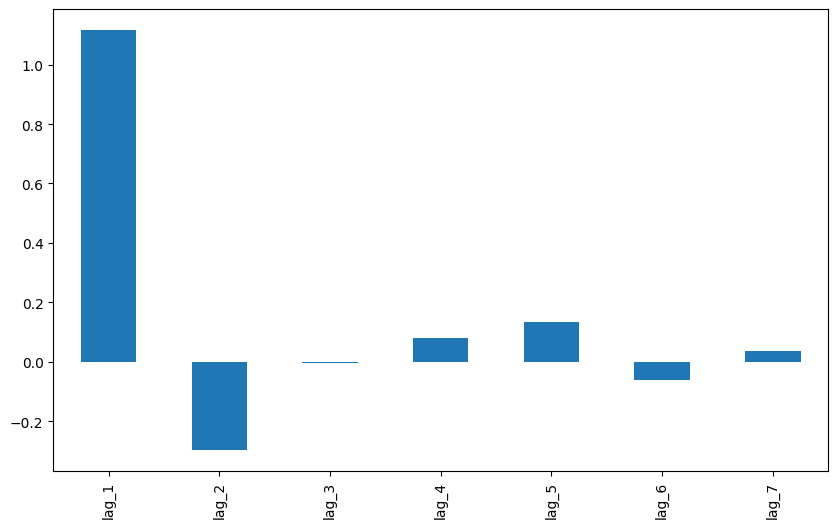

In [186]:
regd.mean().plot(kind='bar', figsize=(10, 6));

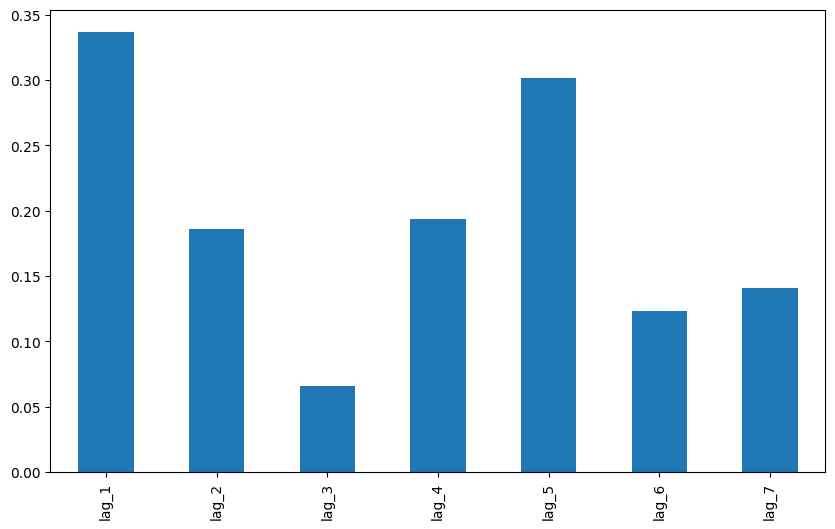

In [187]:
regd.std().plot(kind='bar', figsize=(10, 6));

In [188]:
dfs[sym].corr()

,Volume,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Volume,1.000000,0.381497,0.125958,-0.034732,-0.128540,0.196113,0.021853,0.200190
lag_1,0.381497,1.000000,0.312445,0.060004,-0.070441,-0.110477,0.190858,0.030194
lag_2,0.125958,0.312445,1.000000,0.161813,-0.061818,-0.131371,-0.107659,0.173721
lag_3,-0.034732,0.060004,0.161813,1.000000,0.046382,-0.083699,-0.152736,-0.125730
lag_4,-0.128540,-0.070441,-0.061818,0.046382,1.000000,0.054510,-0.092324,-0.152535
lag_5,0.196113,-0.110477,-0.131371,-0.083699,0.054510,1.000000,0.044375,-0.073400
lag_6,0.021853,0.190858,-0.107659,-0.152736,-0.092324,0.044375,1.000000,0.040035
lag_7,0.200190,0.030194,0.173721,-0.125730,-0.152535,-0.073400,0.040035,1.000000


In [189]:
from statsmodels.tsa.stattools import adfuller

# **Augmented Dickey-Fuller**

In [190]:
adfuller(data[sym].dropna())

(-3.6196126251513348,
 0.005396958468360957,
 3,
 187,
 {'1%': -3.465811691080702,
  '5%': -2.877123351472649,
  '10%': -2.5750770662586864},
 6308.846438280445)

In [191]:
rets = np.log(data_0 / data_0.shift(1))

In [192]:
rets.dropna(inplace=True)

In [193]:
dfs = {}
for sym in data_0:
    df, cols= add_lags(rets, sym, lags)
    mu, std = df[cols].mean(), df[cols].std()
    df[cols] = (df[cols]- mu) / std
    dfs[sym] =df

In [194]:
dfs[sym].head()

,Volume,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2023-08-11,0.314927,-0.755397,-1.661055,1.423018,0.098472,0.357793,-1.292591,0.646730
2023-08-14,-0.092230,1.257286,-0.699004,-1.646116,1.454530,0.098915,0.378801,-1.314870
2023-08-15,0.287402,-0.450908,1.244443,-0.702171,-1.641769,1.455191,0.125701,0.350351
2023-08-16,0.084226,1.141807,-0.404989,1.204700,-0.689469,-1.641605,1.451705,0.098186
2023-08-17,-0.238458,0.289399,1.132938,-0.413690,1.234280,-0.689152,-1.575970,1.419293


In [195]:
adfuller(dfs[sym]['lag_1'])

(-9.749816290155438,
 8.071882451912093e-17,
 0,
 38,
 {'1%': -3.6155091011809297,
  '5%': -2.941262357486514,
  '10%': -2.6091995013850418},
 77.87993861505025)

In [196]:
dfs[sym].corr()

,Volume,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Volume,1.000000,-0.436000,-0.000800,-0.009999,-0.271675,0.311318,-0.198020,0.213313
lag_1,-0.436000,1.000000,-0.394140,-0.016771,0.001213,-0.272174,0.326781,-0.216121
lag_2,-0.000800,-0.394140,1.000000,-0.426298,-0.009595,-0.009773,-0.201562,0.280156
lag_3,-0.009999,-0.016771,-0.426298,1.000000,-0.435913,-0.003774,-0.054916,-0.163917
lag_4,-0.271675,0.001213,-0.009595,-0.435913,1.000000,-0.447146,-0.002948,-0.045062
lag_5,0.311318,-0.272174,-0.009773,-0.003774,-0.447146,1.000000,-0.447799,0.007163
lag_6,-0.198020,0.326781,-0.201562,-0.054916,-0.002948,-0.447799,1.000000,-0.460730
lag_7,0.213313,-0.216121,0.280156,-0.163917,-0.045062,0.007163,-0.460730,1.000000


# **Prediction Accuracy_score**

In [197]:
from sklearn.metrics import accuracy_score

In [198]:
%%time
for sym in data_0:
    df =dfs[sym]
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    pred = np.dot(df[cols], reg)
    acc= accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'OLS | {sym:10s} | acc={acc:.4f}')

OLS | Open       | acc=0.6154
OLS | High       | acc=0.6667
OLS | Low        | acc=0.5897
OLS | Close      | acc=0.5897
OLS | Adj Close  | acc=0.5641
OLS | Volume     | acc=0.7436
CPU times: user 32.1 ms, sys: 0 ns, total: 32.1 ms
Wall time: 45.9 ms


## Mean-Variance Portfolio Theory

In [199]:
data_stock = np.log(data_0.shift(1)).dropna()

In [200]:
weights = len(data_stock.columns) * [1/len(data_stock.columns)]

In [201]:
def port_return(data_stock,  weights):
    return np.dot(data_stock.mean(), weights)

In [204]:
port_return(data_stock, weights)

5.710732421772001

In [205]:
def port_volatility(data_stock, weights):
    return np.dot(weights, np.dot(data_stock.cov() * 252, weights)) ** 0.5

In [206]:
port_volatility(data_stock, weights)

0.612328648444693

In [207]:
def port_sharpe(data_stock, weights):
    return port_return(data_stock, weights) / port_volatility(data_stock, weights)

In [208]:
port_sharpe(data_stock, weights)

9.326253861022488

In [209]:
w = np.random.random((1000, len(data_0)))
w = (w.T / w.sum(axis=1)).T

In [210]:
w[:5]

array([[0.02907849, 0.02184421, 0.03946823, 0.03060714, 0.00363353,
        0.01445328, 0.02850222, 0.02559675, 0.01927493, 0.00317862,
        0.01209216, 0.0079115 , 0.02771331, 0.02934978, 0.01106174,
        0.0341969 , 0.03469253, 0.00449677, 0.00662981, 0.00774468,
        0.01385437, 0.02914083, 0.02406281, 0.00302838, 0.00055491,
        0.03881399, 0.01114687, 0.02439114, 0.01303642, 0.00167162,
        0.03276938, 0.03569189, 0.02682853, 0.03802362, 0.00988335,
        0.04031565, 0.03338747, 0.00568677, 0.0425215 , 0.02171882,
        0.01701335, 0.04005884, 0.00539324, 0.00643364, 0.04359732,
        0.0325852 , 0.01686351],
       [0.03895199, 0.02532889, 0.01598227, 0.00994536, 0.03859484,
        0.03180179, 0.00819168, 0.03242295, 0.03201096, 0.04274467,
        0.03550225, 0.00199439, 0.02627688, 0.03758728, 0.00449402,
        0.01674004, 0.03024777, 0.01803021, 0.02232599, 0.01172569,
        0.01004589, 0.01998752, 0.04645884, 0.00760386, 0.03490626,
        0.02956